In [5]:
# Importo las bibliotecas de OpenCV, Numpy y Matplotlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Parte 1

Cargo template e imagen donde se realizara la deteccion

In [6]:
# template = cv2.imread('./template/pattern.png', cv2.IMREAD_GRAYSCALE)
template = cv2.imread('./template/pattern.png')
assert template is not None, "file could not be read, check with os.path.exists()"
# template = img2coordCromatica(template)
template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
w, h = template.shape[::-1]

# img = cv2.imread('./images/coca_multi.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('./images/coca_retro_2.png')
assert img is not None, "file could not be read, check with os.path.exists()"
# img = img2coordCromatica(img)
imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
Wimg, Himg = imgGray.shape[::-1]


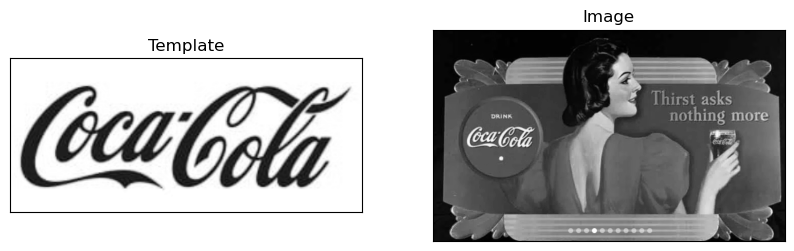

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(121),plt.imshow(template, cmap = 'gray')
plt.title('Template'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(imgGray, cmap = 'gray')
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.show()

Se realiza la implementación de un detector con técnicas de Feature Matching para la detección de puntos característicos en las imágenes y la relación entre estos entre las dos imágenes.

Para esto se implementaron 2 métodos para la detección de los puntos SIFT y ORB. 
La relación entre los puntos detectados en las 2 imágenes se realiza con FlannBasedMatcher.

Las coincidencias encontradas se pasan el test de Lowe's mejorar la confianza.


El método SIFT demostró se mejor para este caso, esto se debe a que obtiene sus puntos en las curvas de la imagen.


## Feature Matching + Homography to find Objects

La función **encontrarCoincidencias** detecta los puntos de coincidencia entre 2 imágenes (el templete y la imagen analizar).

A esta función se le ingresa:

imgQuery: imagen del témplate.

imgTrain: imagen a analizar.

MIN_MATCH_COUNT: cantidad mínima de coincidencias para que se considere la detección como valida.

method: método por el que se detectan los puntos en las imágenes (SIFT u ORB).

esSegundaBusqueda: variable para uso interno de la función.


Salida: 
good: detecciones realizadas.

kp1: puntos en imagen 1.

kp2: puntos en imagen 2.


Si la función no logra obtener una cantidad de coincidencias que pase el umbral dado(MIN_MATCH_COUNT), vuelve a realizar la detección pero invirtiendo los colores de la imagen del témplate. Esto proporciono grandes mejoras en algunos casos.

**dibujarCoincidencias**: Coloca las 2 imágenes en una sola, traza las coincidencias entre estas, y si dispone de la cantidad suficiente de puntos dibuja la proyección del perímetro de la imagen témplate sobre la imagen a detectar.

**dividirImagenEnGrillas**: divide la imagen en la cantidad de grillas indicada.


La otra función importante es **detectarTemplateEnImagen**, esta función va a utilizar la función **encontrarCoincidencias** para detectar el témplate en la imagen en diferentes escalas y grillas según los parámetros de entrada.

Valores de entrada:

imgQuery: imagen del témplate.

imgTrain: imagen a analizar.

MIN_MATCH_COUNT: cantidad mínima de coincidencias para que se considere la detección como valida.

escalas: arreglo de escalas en las que se usara la imagen. Ej: [0.5,1,2].

grillasDeDeteccion: cantidad de grillas en las que se dividirá la imagen. Aplica para todas las escalas.

method: método por el que se detectan los puntos en las imágenes (SIFT u ORB).

mostrarImagen: Bolean, indica si se muestran las detecciones que se van realizando en la consola de salida.

cantidadDeDeteccionADevolver: Int, indica la cantidad de detecciones que se quiere de retorno. Estas están ordenadas de mayor a menor según la cantidad de puntos de coincidencia encontrados.



In [7]:
def encontrarCoincidencias(imgQuery,imgTrain,MIN_MATCH_COUNT=10,method='SIFT',esSegundaBusqueda=False):
    if method == 'SIFT':
        # Initiate SIFT detector
        sift = cv2.SIFT_create()
        # find the keypoints and descriptors with SIFT
        kp1, des1 = sift.detectAndCompute(imgQuery,None)
        kp2, des2 = sift.detectAndCompute(imgTrain,None)
        # FLANN parameters for SIFT
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    elif method == 'ORB':
        # Initiate ORB detector
        orb = cv2.ORB_create()
        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(imgQuery,None)
        kp2, des2 = orb.detectAndCompute(imgTrain,None)
        # FLANN parameters for ORB
        FLANN_INDEX_LSH = 6
        index_params= dict(algorithm = FLANN_INDEX_LSH,
                        table_number = 12, # 12
                        key_size = 20,     # 20
                        multi_probe_level = 2)
    
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # quita los matches que tienen un solo punto (problema con ORB)
    matches = [m for m in matches if len(m)==2]
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    # si no encuentra coincidencias, busco con imgQuery invertida 
    if len(good)<MIN_MATCH_COUNT and not esSegundaBusqueda:
        imgQueryInv = cv2.bitwise_not(imgQuery)
        good_inv, kp1_inv, kp2_inv = encontrarCoincidencias(imgQueryInv,imgTrain, 
                                                MIN_MATCH_COUNT=MIN_MATCH_COUNT, 
                                                method=method, 
                                                esSegundaBusqueda=True)
        # si encuentro mas coincidencias, las guardo
        if len(good_inv)>len(good):
            good = good_inv
            kp1 = kp1_inv
            kp2 = kp2_inv

    return good, kp1, kp2

def dibujarCoincidencias(imgQuery,imgTrain,good,kp1,kp2,MIN_MATCH_COUNT=10):
    # crea recuadro de deteccion
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = imgQuery.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        imgTrain = cv2.polylines(imgTrain,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    # dibuja coincidencias
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    imgSalida = cv2.drawMatches(imgQuery,kp1,imgTrain,kp2,good,None,**draw_params)

    return imgSalida

# funcion para dividir la imagen en grillas
def dividirImagenEnGrillas(img, grillasDeDeteccion=2):
    # obtengo el alto y ancho de la imagen
    alto, ancho = img.shape[:2]
    # obtengo el alto y ancho de cada grilla
    altoGrilla = alto // grillasDeDeteccion
    anchoGrilla = ancho // grillasDeDeteccion
    # lista para guardar las grillas
    grillas = list()
    # recorro las grillas
    for i in range(grillasDeDeteccion):
        for j in range(grillasDeDeteccion):
            # obtengo la grilla
            grilla = img[altoGrilla*i:altoGrilla*(i+1), anchoGrilla*j:anchoGrilla*(j+1)]
            # guardo la grilla
            grillas.append(grilla)
    return grillas

def detectarTemplateEnImagen(imgQuery,imgTrain,MIN_MATCH_COUNT=10,escalas=[1], 
                             grillasDeDeteccion=1, method = 'SIFT', 
                             mostrarImagen = True, cantidadDeDeteccionADevolver = 1):
    # lista para guardar las detecciones
    detecciones = list()
    # recorro las escalas
    for escala in escalas:
        # escalado de la imagen
        imgTrainEscalada = cv2.resize(imgTrain, (0,0), fx=escala, fy=escala)
        # encuentra coincidencias
        good, kp1, kp2 = encontrarCoincidencias(imgQuery,imgTrainEscalada, MIN_MATCH_COUNT=MIN_MATCH_COUNT, method=method)
        # guarda las detecciones
        detecciones.append((escala,imgTrainEscalada,-1,good,kp1,kp2)) # -1 para indicar que no es grilla
        # si tiene mas de una grilla de deteccion, las recorro y guardo las detecciones
        if grillasDeDeteccion > 1:
            # divido la imagen en grillas
            grillas = dividirImagenEnGrillas(imgTrainEscalada, grillasDeDeteccion=grillasDeDeteccion)
            # recorro las grillas y busco coincidencias
            for i,grilla in enumerate(grillas):
                try:
                    # encuentra coincidencias
                    good, kp1, kp2 = encontrarCoincidencias(imgQuery,grilla, MIN_MATCH_COUNT=MIN_MATCH_COUNT, method=method)
                    # guarda las detecciones
                    detecciones.append((escala,grilla,i,good,kp1,kp2))
                except:
                    detecciones.append((escala,grilla,i,[],[],[])) # si no encuentra coincidencias, guardo una lista vacia


    # ordena las detecciones por cantidad de coincidencias
    detecciones.sort(key=lambda tup: len(tup[3]), reverse=True) # tup[3] es la lista de coincidencias(good)

    imgSalida = list()
    for escala,imgTrainSalida,indexGrilla,good,kp1,kp2 in detecciones[:cantidadDeDeteccionADevolver]:
        try:
            # dibuja coincidencias
            if len(good)>0:
                imgSalidaAux = dibujarCoincidencias(imgQuery,imgTrainSalida,good,kp1,kp2,MIN_MATCH_COUNT)
            else:
                imgSalidaAux = imgTrainSalida
                
            imgSalida.append(imgSalidaAux)

            # muestra la imagen
            if mostrarImagen:
                plt.title('Deteccion de template, escala ' + str(escala) + ', grilla ' + str(indexGrilla) + ', puntos encontrados: ' + str(len(good)) ), plt.xticks([]), plt.yticks([])
                plt.imshow(imgSalidaAux, 'gray'),plt.show()
        except:
            pass
    
    return imgSalida, detecciones


Se realiza la detección en las imágenes.

In [6]:
direccionesImagenesParaAnalizar = ['./images/COCA-COLA-LOGO.jpg','./images/coca_multi.png',
                                    './images/coca_retro_1.png','./images/coca_retro_2.png',
                                    './images/coca_logo_1.png','./images/coca_logo_2.png',
                                    './images/logo_1.png']



Se utiliza el kernel y las imágenes en escalas de grises para hacerlas independientes del color y solo concentrarse en la morfología.

Analizando imagen: ./images/COCA-COLA-LOGO.jpg
Escalas generadas: [0.5 1.5 2.5]


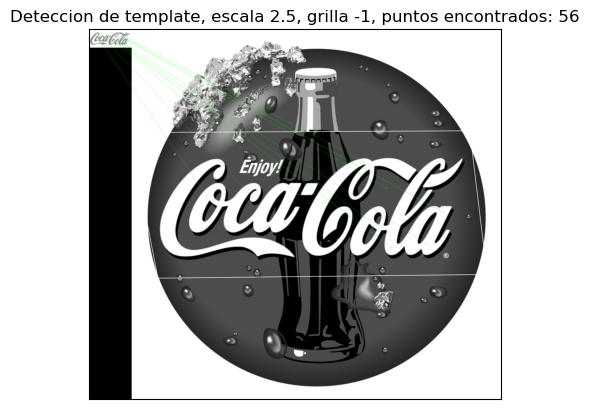

Analizando imagen: ./images/coca_multi.png
Escalas generadas: [0.5 1.5 2.5]


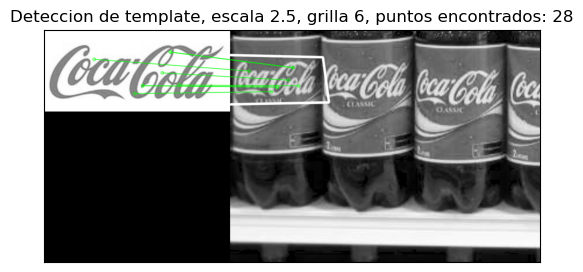

Analizando imagen: ./images/coca_retro_1.png
Escalas generadas: [0.5 1.5 2.5]


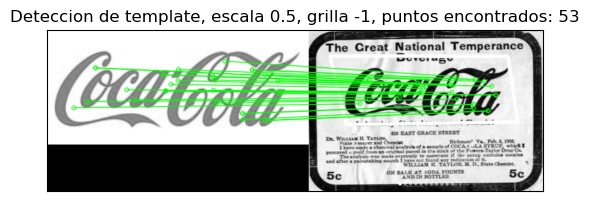

Analizando imagen: ./images/coca_retro_2.png
Escalas generadas: [0.5 1.5 2.5]


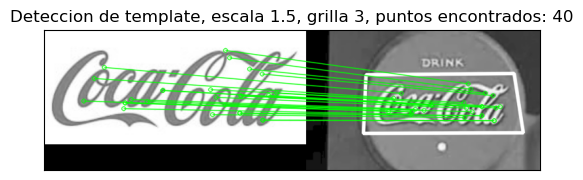

Analizando imagen: ./images/coca_logo_1.png
Escalas generadas: [0.5 1.5 2.5]


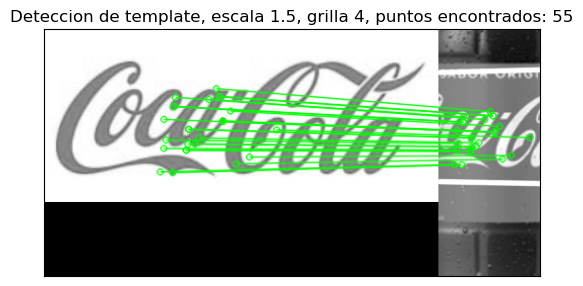

Analizando imagen: ./images/coca_logo_2.png
Escalas generadas: [0.5 1.5 2.5]


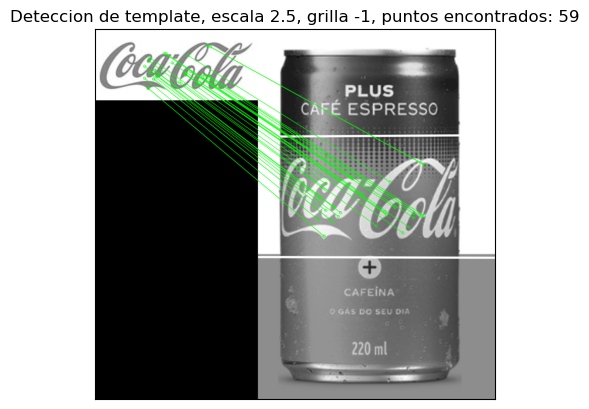

Analizando imagen: ./images/logo_1.png
Escalas generadas: [0.5 1.5 2.5]


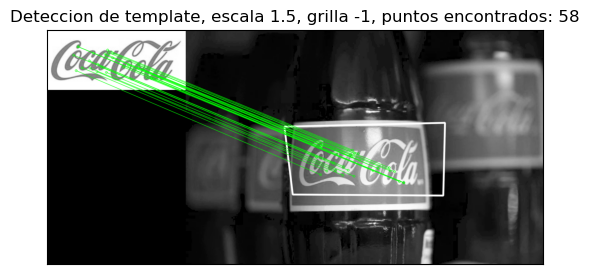

In [7]:
MIN_MATCH_COUNT = 10
imgADetectar = cv2.imread('./template/pattern.png', cv2.IMREAD_GRAYSCALE) # queryImage

# lista para imagenes analizadas
imagenesAnalizadas = list()
# Recorro todas las imagenes para analizar
for imgAnalizar in direccionesImagenesParaAnalizar:
    img = cv2.imread(imgAnalizar, cv2.IMREAD_GRAYSCALE) # trainImage
    print(f'Analizando imagen: {imgAnalizar}')

    # genero varias escalas de la imagen para poder encontrar el template
    escalas = np.linspace(0.5, 2.5, 3)
    print(f'Escalas generadas: {escalas}')
    detectarTemplateEnImagen(imgADetectar, # imagen del template que se quiere localizar
                             img, #imagen donde se quiere localizar el template
                             MIN_MATCH_COUNT=MIN_MATCH_COUNT, # cantidad minima de coincidencias
                             escalas=escalas, # arreglos de escalas para analizar
                             method='SIFT', # 'SIFT' o 'ORB' | en este caso SIFT es mas preciso ya que detecta mejor las curvas de la imagen
                             grillasDeDeteccion=3, #cantidad de grillas en las que se divide la imagen para analizar
                             mostrarImagen=True, #muestra la imagen
                             cantidadDeDeteccionADevolver=1 #siepre se devuelve la mejor deteccion
                             )



Se puedo realizar con éxito al menos 1 detección por imagen con las funciones generadas.

# Parte 2

Se reutilizan las funciones generadas en el punto anterior para realizar una implementación donde se puedan detectar múltiples coincidencias por imagen.

Para esto se generan 2 funciones:

**detectarTemplateEnImagenMultiple** que utiliza la función **detectarTemplateEnImagen** para obtener las detecciones en la imagen. Obtiene los puntos de detección en diferentes escalas y los traslada a la escala original. También permite volver a correr la detección colocando una mascara en los Logos ya detectados para obtener nuevas coincidencias.

Ingreso:

imgQuery: imagen del témplate.

imgTrain: imagen a analizar.

MIN_MATCH_COUNT: cantidad mínima de coincidencias para que se considere la detección como valida.

escalas: arreglo de escalas en las que se usara la imagen. Ej: [0.5,1,2].

grillasDeDeteccion: cantidad de grillas en las que se dividirá la imagen. Aplica para todas las escalas.

method: método por el que se detectan los puntos en las imágenes (SIFT u ORB).

mostrarImagen: Bolean, indica si se muestran las detecciones que se van realizando en la consola de salida.

cantidadDeDeteccionADevolverPorBucle: Int, indica la cantidad de detecciones que se quiere de retorno. Estas están ordenadas de mayor a menor según la cantidad de puntos de coincidencia encontrados.

cantidadDeBuclesMaxima: Int, se indica la cantidad máxima de bucles que se permite para la deteccion. Colocar en -1 para que se detenga solo cuando no encuentre mas coincidencias.

La función **eliminarDeteccionesSolapadas** recibe las detecciones y se encarga de liminar los solapamientos entre estas. Descarta las detecciones que tienen un área menor a 100 y las detecciones que tienen un área del 30% o más ya detectada por otras.


In [8]:
direccionesImagenesParaAnalizar = ['./images/coca_multi.png']


In [9]:
def detectarTemplateEnImagenMultiple(imgQuery,imgTrain,MIN_MATCH_COUNT=10,escalas=[1], 
                                    grillasDeDeteccion=1, method = 'SIFT', 
                                    mostrarImagen = True, 
                                    cantidadDeDeteccionADevolverPorBucle = 1, 
                                    cantidadDeBuclesMaxima = 1):
    
    imagenSalida = imgTrain.copy()
    imagenMascara = imgTrain.copy()
    
    imagenes, detecciones = detectarTemplateEnImagen(imgQuery, imgTrain, 
                             MIN_MATCH_COUNT=MIN_MATCH_COUNT,
                             escalas=escalas,
                             method=method,
                             grillasDeDeteccion=grillasDeDeteccion,
                             mostrarImagen=mostrarImagen,
                             cantidadDeDeteccionADevolver = cantidadDeDeteccionADevolverPorBucle)
        
    # print(f'Cantidad de detecciones: {len(detecciones)}')
    # print(f'Cantidad de imagenes: {len(imagenes)}')
    # print(f'Cantidad de detecciones por imagen: {[len(deteccion[3]) for deteccion in detecciones]}')
    # print(f'Grillas: {[deteccion[2] for deteccion in detecciones]}')

    # Elimina las detecciones que tienen menos de MIN_MATCH_COUNT coincidencias
    # detecciones = [deteccion for deteccion in detecciones if len(deteccion[3]) > MIN_MATCH_COUNT]
    detecciones = list(filter(lambda deteccion: len(deteccion[3]) > MIN_MATCH_COUNT, detecciones))
    # print(f'Cantidad de detecciones despues de eliminar las que tienen menos de {MIN_MATCH_COUNT} coincidencias: {len(detecciones)}')
    # ordena las detecciones por cantidad de coincidencias

    # Lista de detecciones finales
    deteccionesFinales = list()
    # recorro las detecciones y grafico las que tienen mas coincidencias
    for escala,imgTrainSalida,indexGrilla,good,kp1,kp2 in detecciones[:cantidadDeDeteccionADevolverPorBucle]:
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)           

            # Si M es None, no se pudo calcular la homografia
            if M is None:
                continue

            h,w = imgQuery.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            
            dst = cv2.perspectiveTransform(pts,M)
            
            # busca la transformada de la grilla a la imagen original
            # para poder dibujar la grilla en la imagen original
            hS,wS = imgTrainSalida.shape
            # se traslada la grilla a la posicion original
            trasladosEnX = (indexGrilla % grillasDeDeteccion)
            trasladosEnY = (indexGrilla // grillasDeDeteccion)
            # se escala la grilla
            dst = ( dst + np.float32([[trasladosEnX*wS, trasladosEnY*hS]]) ) / escala

            imagenSalida = cv2.polylines(imagenSalida,[np.int32(dst)],True,255,3, cv2.LINE_AA)
            imagenMascara = cv2.fillPoly(imagenMascara,[np.int32(dst)],255) # mascara para eliminar las detecciones que ya se encontraron

            # agrega el poligono a la lista de detecciones finales
            deteccionesFinales.append(dst)

        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )



    # plt.title('Deteccion de template Multiple'), plt.xticks([]), plt.yticks([])
    # plt.imshow(imagenSalida, 'gray'),plt.show()
    # plt.imshow(imagenMascara, 'gray'),plt.show()

    # print(f'Detecciones bucle: {len(deteccionesFinales)}')
    # si la cantidad de detecciones finales es mayor a 0 se vuelve a analizar la imagen con la mascara
    if len(deteccionesFinales) > 0 and (cantidadDeBuclesMaxima > 0 or cantidadDeBuclesMaxima == -1):
        deteccionesBucle = detectarTemplateEnImagenMultiple(imgQuery, imagenMascara,
                                                            MIN_MATCH_COUNT=MIN_MATCH_COUNT,
                                                            escalas=escalas,
                                                            method=method,
                                                            grillasDeDeteccion=grillasDeDeteccion,
                                                            mostrarImagen=mostrarImagen,                                                            
                                                            cantidadDeDeteccionADevolverPorBucle = cantidadDeDeteccionADevolverPorBucle,
                                                            cantidadDeBuclesMaxima = cantidadDeBuclesMaxima - 1 if cantidadDeBuclesMaxima != -1 else -1)
        # se agregan las detecciones del bucle a las detecciones finales
        deteccionesFinales.extend(deteccionesBucle)
        
    # se devuelve las detecciones finales
    return deteccionesFinales


def eliminarDeteccionesSolapadas(img, detecciones):
    # se ordenan las detecciones de mayor a menor
    detecciones.sort(key=lambda x: cv2.contourArea(x), reverse=True)

    # busca el tamaño maximo h y w de la imagen
    hMax = img.shape[0]
    wMax = img.shape[1]

    # se recorren las detecciones
    for i in range(len(detecciones)):
        # controlo que el range no se salga del array
        if i >= len(detecciones):
            break
        # print(f'Analizando deteccion {i}')
        # print(f'Area: {cv2.contourArea(detecciones[i])}')

        # si el area es menor a 100 se elimina
        if cv2.contourArea(detecciones[i]) < 100:
            # print(f'Eliminando deteccion {i} por ser muy pequeña')
            detecciones.pop(i)
            i -= 1
            continue

        imgI = np.zeros((hMax,wMax), np.uint8)
        imgI = cv2.fillPoly(imgI,[np.int32(detecciones[i])],255)

        imgJ = np.zeros((hMax,wMax), np.uint8)
        # se recorren todas las otras detecciones 
        for j in range(len(detecciones)):
            if j != i:
                # se agregan las detecciones a una imagen
                imgJ = cv2.fillPoly(imgJ,[np.int32(detecciones[j])],255)

        # se calcula la interseccion entre la deteccion i y todas las demas
        interseccion = cv2.bitwise_and(imgI, imgJ)
        areaInterseccion = cv2.countNonZero(interseccion)

        # print(f'Area interseccion con deteccion {i}: {areaInterseccion}')
        # si la interseccion es mayor al 30% de la deteccion
        # se elimina la deteccion i por tener sub detecciones dentro
        if areaInterseccion > 0.3 * cv2.contourArea(detecciones[i]):
            # print(f'Eliminando deteccion {i}')
            detecciones.pop(i)
            i -= 1
            continue

    return detecciones

# dibuja cada deteccion con un color diferente
def dibujarDeteciones(img, detecciones):
    imagenSalida = img.copy()
    for deteccion in detecciones:
        imagenSalida = cv2.polylines(imagenSalida,[np.int32(deteccion)],True,255,3, cv2.LINE_AA)
    return imagenSalida

Se realiza la detección de los logos de coca cola en la imagen del estante.

Los resultados varian segun los paramentros que se utilicen en la funcion **detectarTemplateEnImagenMultiple**.

Analizando imagen: ./images/coca_multi.png
Escalas generadas: [2.]
Cantidad de detecciones : 22
Cantidad de detecciones despues de eliminar solapamientos: 21


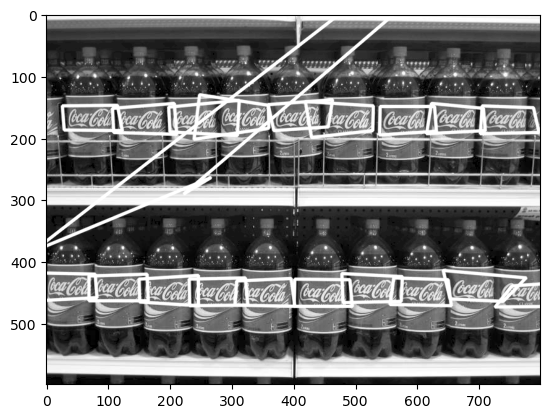

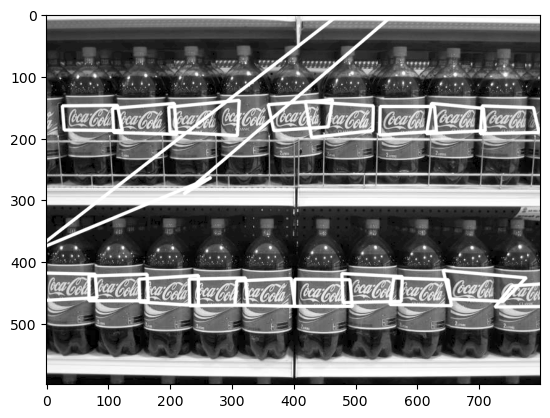

In [28]:
MIN_MATCH_COUNT = 9
imgADetectar = cv2.imread('./template/pattern.png', cv2.IMREAD_GRAYSCALE) # queryImage

# lista para imagenes analizadas
imagenesAnalizadas = list()
# Recorro todas las imagenes para analizar
for imgAnalizar in direccionesImagenesParaAnalizar:
    img = cv2.imread(imgAnalizar, cv2.IMREAD_GRAYSCALE) # trainImage
    print(f'Analizando imagen: {imgAnalizar}')

    # genero varias escalas de la imagen para poder encontrar el template
    escalas = np.linspace(2, 2, 1)
    print(f'Escalas generadas: {escalas}')
    detecciones = detectarTemplateEnImagenMultiple(imgADetectar, img, 
                             MIN_MATCH_COUNT=MIN_MATCH_COUNT,
                             escalas=escalas,
                             method='SIFT', # 'SIFT' o 'ORB'
                             grillasDeDeteccion=5,
                             mostrarImagen=False,
                             cantidadDeDeteccionADevolverPorBucle=5,
                             cantidadDeBuclesMaxima=4)
    
    # elimina las detecciones con un area menor a 10
    detecciones = list(filter(lambda x: cv2.contourArea(x) > 10, detecciones))
    print(f'Cantidad de detecciones : {len(detecciones)}')

    # dibujo las detecciones
    imgAnalizada = dibujarDeteciones(img, detecciones)
    imagenesAnalizadas.append(imgAnalizada)

    # analiza si hay detecciones finales que se solapan
    # si hay se elimina la que tenga menos coincidencias
    deteccionesFiltradas = eliminarDeteccionesSolapadas(img,detecciones)
    print(f'Cantidad de detecciones despues de eliminar solapamientos: {len(deteccionesFiltradas)}')
    imgAnalizadaFiltrada = dibujarDeteciones(img, deteccionesFiltradas)
    imagenesAnalizadas.append(imgAnalizadaFiltrada)

# muestro las imagenes analizadas
for img in imagenesAnalizadas:
    plt.imshow(img, 'gray'),plt.show()
    

Se observa en las imágenes de salida (superior detecciones sin filtrar, inferior detecciones filtradas), como se pudo realizar la detección de todos los logos. También se observa una detección errores que al realizar el filtrado de copamientos elimina una detección correcta. Estos son puntos para analizar en posibles mejoras del código.

# Parte 3

El código generado en el punto 2 ya es capaz de realizar la detección en múltiples logos en todas las imágenes dadas.

Se reutiliza este código y de cambian los parámetros de la detección para obtener las detecciones deseadas en todas las imágenes.

In [10]:
direccionesImagenesParaAnalizar = ['./images/COCA-COLA-LOGO.jpg','./images/coca_multi.png',
                                    './images/coca_retro_1.png','./images/coca_retro_2.png',
                                    './images/coca_logo_1.png','./images/coca_logo_2.png',
                                    './images/logo_1.png']


Analizando imagen: ./images/COCA-COLA-LOGO.jpg
Escalas generadas: [0.75  1.375 2.   ]
Cantidad de detecciones : 5
Cantidad de detecciones despues de eliminar solapamientos: 4


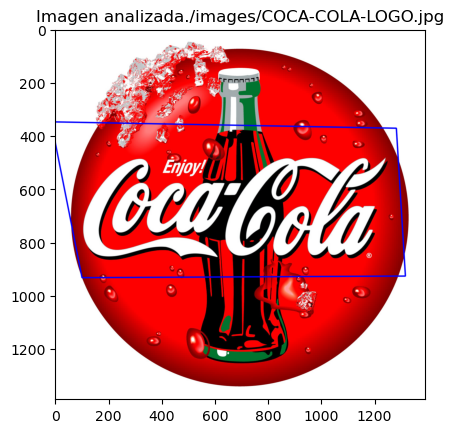

Analizando imagen: ./images/coca_multi.png
Escalas generadas: [0.75  1.375 2.   ]
Cantidad de detecciones : 24
Cantidad de detecciones despues de eliminar solapamientos: 16


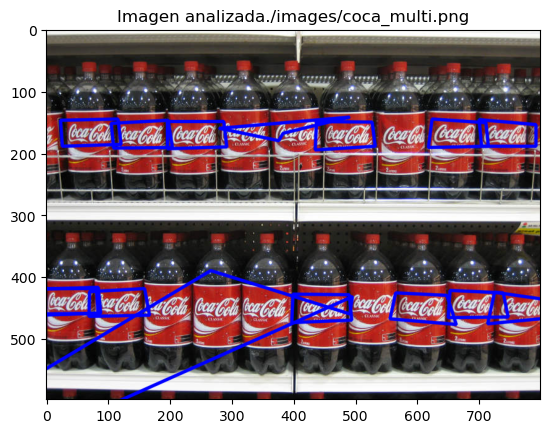

Analizando imagen: ./images/coca_retro_1.png
Escalas generadas: [0.75  1.375 2.   ]
Cantidad de detecciones : 4
Cantidad de detecciones despues de eliminar solapamientos: 4


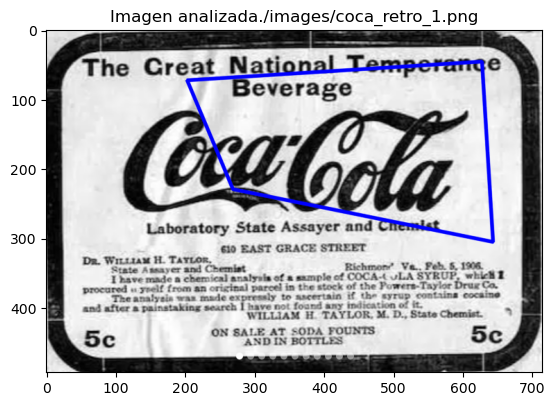

Analizando imagen: ./images/coca_retro_2.png
Escalas generadas: [0.75  1.375 2.   ]
Cantidad de detecciones : 5
Cantidad de detecciones despues de eliminar solapamientos: 3


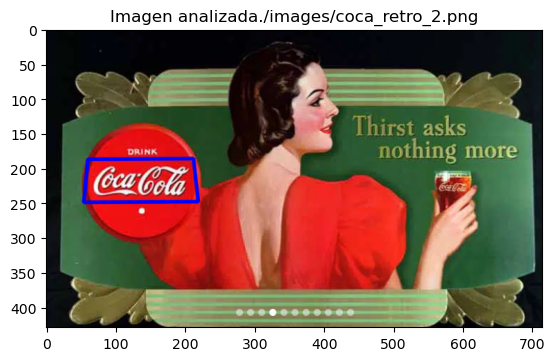

Analizando imagen: ./images/coca_logo_1.png
Escalas generadas: [0.75  1.375 2.   ]
Cantidad de detecciones : 5
Cantidad de detecciones despues de eliminar solapamientos: 4


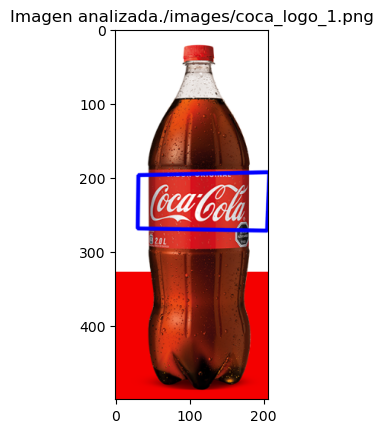

Analizando imagen: ./images/coca_logo_2.png
Escalas generadas: [0.75  1.375 2.   ]
Cantidad de detecciones : 4
Cantidad de detecciones despues de eliminar solapamientos: 4


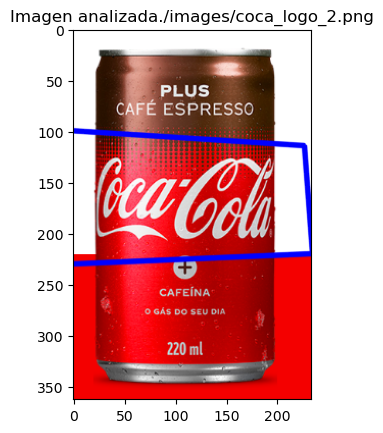

Analizando imagen: ./images/logo_1.png
Escalas generadas: [0.75  1.375 2.   ]
Cantidad de detecciones : 5
Cantidad de detecciones despues de eliminar solapamientos: 4


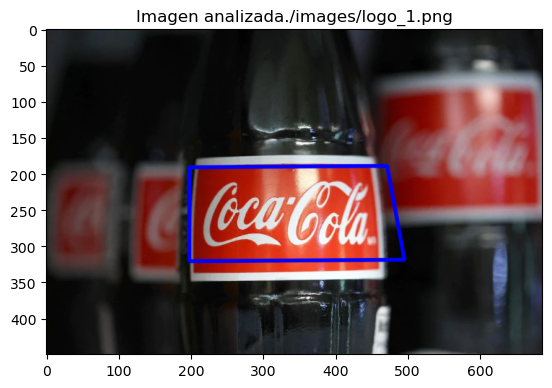

In [19]:
MIN_MATCH_COUNT = 20
imgADetectar = cv2.imread('./template/pattern.png', cv2.IMREAD_GRAYSCALE) # queryImage

# lista para imagenes analizadas
imagenesAnalizadas = list()
# Recorro todas las imagenes para analizar
for imgAnalizar in direccionesImagenesParaAnalizar:
    img = cv2.imread(imgAnalizar, cv2.IMREAD_GRAYSCALE) # trainImage
    print(f'Analizando imagen: {imgAnalizar}')

    # genero varias escalas de la imagen para poder encontrar el template
    escalas = np.linspace(0.75, 2, 3)
    print(f'Escalas generadas: {escalas}')
    detecciones = detectarTemplateEnImagenMultiple(imgADetectar, img, 
                             MIN_MATCH_COUNT=MIN_MATCH_COUNT,
                             escalas=escalas,
                             method='SIFT', # 'SIFT' o 'ORB'
                             grillasDeDeteccion=3,
                             mostrarImagen=False,
                             cantidadDeDeteccionADevolverPorBucle=5,
                             cantidadDeBuclesMaxima=5)
    
    # elimina las detecciones con un area menor a 10
    detecciones = list(filter(lambda x: cv2.contourArea(x) > 100, detecciones))
    print(f'Cantidad de detecciones : {len(detecciones)}')
    # analiza si hay detecciones finales que se solapan
    # si hay se elimina la que tenga menos coincidencias
    imgColores = cv2.imread(imgAnalizar)

    # dibujo las detecciones
    # imgAnalizada = dibujarDeteciones(imgColores, detecciones)
    # imagenesAnalizadas.append(imgAnalizada)

    # Genera mucho consumo de computo y no genera grandes mejoras
    # cuenta el tiempo de ejecucion
    deteccionesFiltradas = eliminarDeteccionesSolapadas(img, detecciones)# se pasa la imagen para tener el tamaño maximo del canvas
    print(f'Cantidad de detecciones despues de eliminar solapamientos: {len(deteccionesFiltradas)}')
    imgAnalizadaFiltrada = dibujarDeteciones(imgColores, deteccionesFiltradas)
    imagenesAnalizadas.append(imgAnalizadaFiltrada)

    plt.title('Imagen analizada' + imgAnalizar)
    plt.imshow(cv2.cvtColor(imgAnalizadaFiltrada, cv2.COLOR_BGR2RGB)),plt.show()

# muestro las imagenes analizadas
# for img in imagenesAnalizadas:
#     plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)),plt.show()

Conclusiones:

Se logro realizar la detección de logos en las imágenes.

Se pueden realizar muchas mejoras en la optimización del código.

No se pudo generar un método que realice una detección automática de las imágenes sin la necesidad de colocar parámetros como las escalas, grillas y cantidad de detecciones de forma manual.